In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import re

%matplotlib inline
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


1. Exploratory data analysis (EDA)
- Preview data
- Check total number of entries and column types
- Check any null values
- Check duplicate entries
- Plot distribution of numeric data (univariate and pairwise joint distribution)
- Look for correlation
- Plot count distribution of categorical data
2. Data cleaning
- Handing missing 
- Replace value
- Transform data
3. Model building
- Visualize results
- Model Diagnostics

## 1. Exploratory data analysis (EDA)
###- Preview data

In [156]:
# get data
train = pd.read_csv('https://raw.githubusercontent.com/dktuananh/pjkaggle/main/train.csv')
train = train.drop('Id', axis=1)
print(train.shape)
train.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


- We have 80 columns and 1460 rows in our dataset. Removed index column, we have 79 feature
- Each row in the dataset describes the characteristics of a house.
Our goal is to predict the SalePrice, given these features.


 mu = 180921.20 and sigma = 79415.29



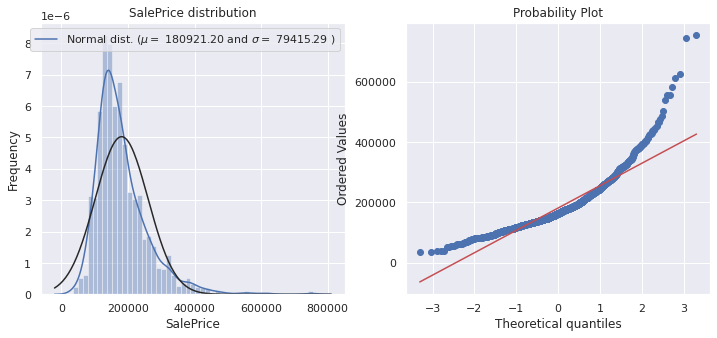

In [157]:
# Target SalePrice
from scipy import stats
from scipy.stats import norm, skew #for some statistics

def feature_distribution(data):
  fig = plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  sns.distplot(data , fit=norm);
  # Get the fitted parameters used by the function
  (mu, sigma) = norm.fit(data)
  print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
  plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
              loc='best')
  plt.ylabel('Frequency')
  plt.title('SalePrice distribution')
  plt.subplot(1,2,2)
  res = stats.probplot(data, plot=plt)

feature_distribution(train['SalePrice'])

Look at the chart above we can see 'SalePrice':
- Deviate from the normal distribution.
- Have appreciable positive skewness.
- Show peakedness.

###- Missing values

In [158]:
#Let's check if the data set has any missing values. 
train.columns[train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [159]:
#missing value counts in each of these columns
Isnull = train.isnull().sum()/len(train)*100
Isnull = Isnull[Isnull>0]
Isnull.sort_values(inplace=True, ascending=False)
Isnull

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

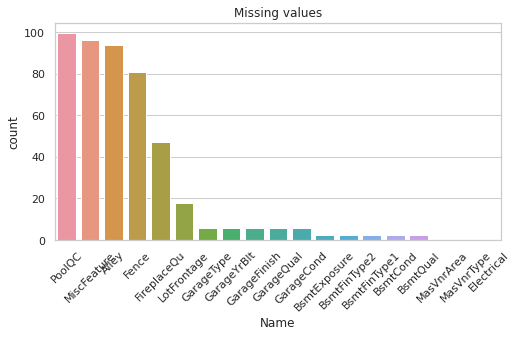

In [160]:
#Convert into dataframe
Isnull = Isnull.to_frame()
Isnull.columns = ['count']
Isnull.index.names = ['Name']
Isnull['Name'] = Isnull.index
#plot Missing values
plt.figure(figsize=(8, 4))
sns.set(style='whitegrid')
sns.barplot(x='Name', y='count', data=Isnull)
plt.xticks(rotation = 45)
plt.title('Missing values')
plt.show()

- Features ['PoolQC', 'MiscFeature', 'Alley', 'Fence'] have the highest number of null values over 80%.
- Maybe it's because the house doesn't have that feature

###- Relationship between Saleprice and features

List all the types of our data from our dataset.

In [161]:
list(set(train.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [162]:
# Numerical and non_numeric classification
def classify_numerical_feature(df):
  numerical = df.select_dtypes(include = ['float64', 'int64']).columns
  non_numerical = df.select_dtypes(include =['category', 'object']).columns
  print('No. numerical_features = ' + str(len(numerical)))
  print('No. non_numerical_features = ' + str(len(non_numerical)))
  return numerical, non_numerical

numerical_features, non_numerical_features = classify_numerical_feature(train)  

No. numerical_features = 37
No. non_numerical_features = 43


In [163]:
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [164]:
non_numerical_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

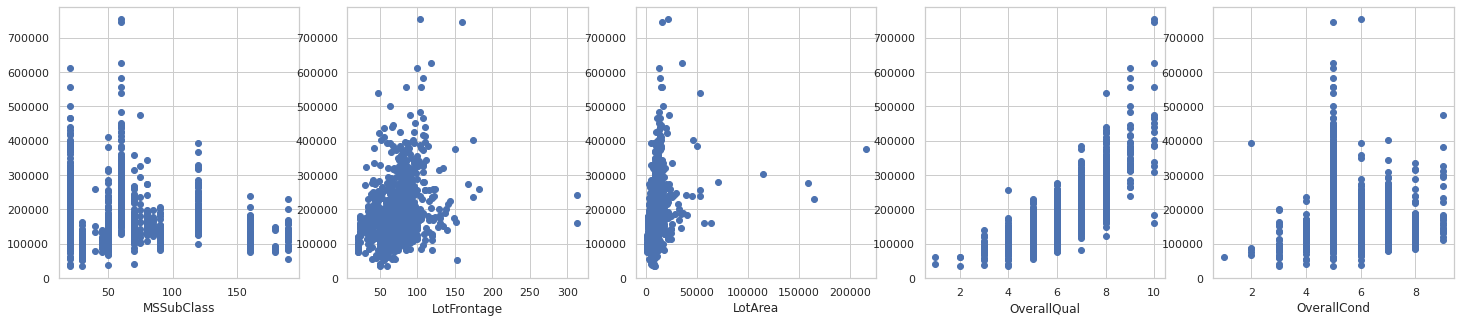

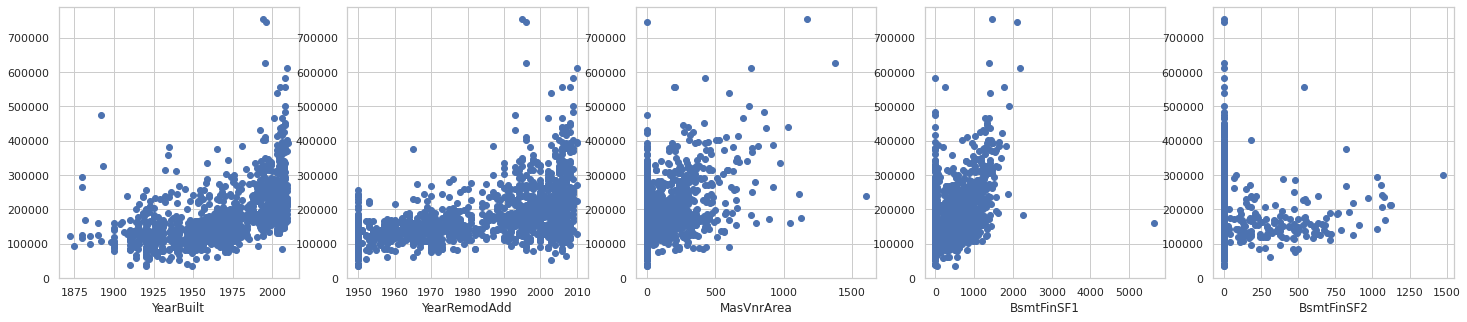

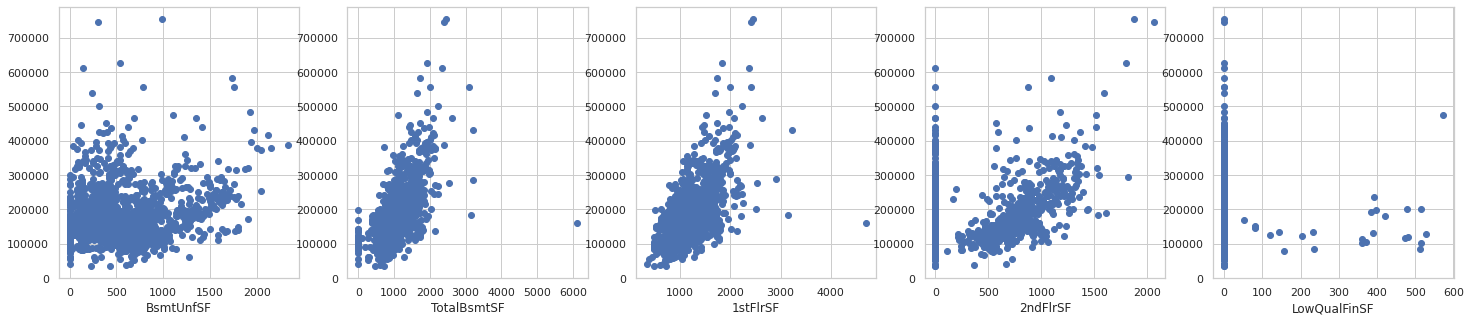

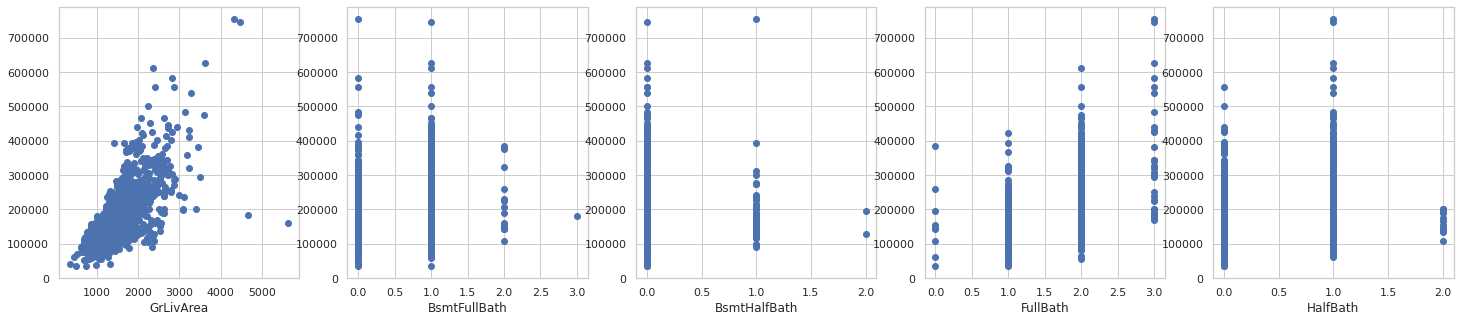

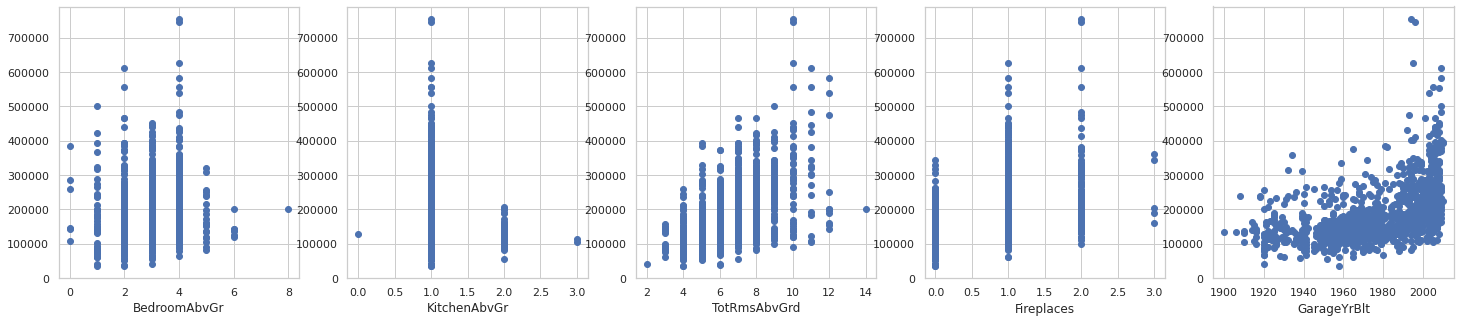

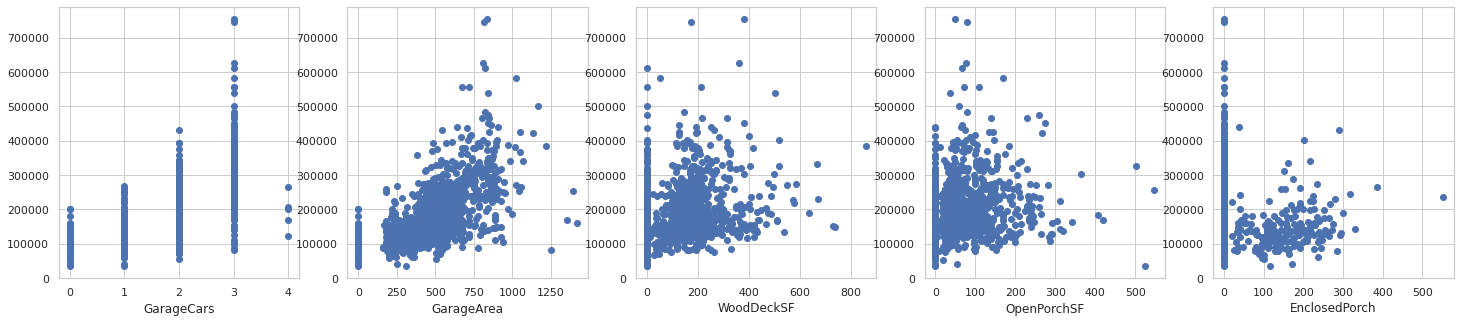

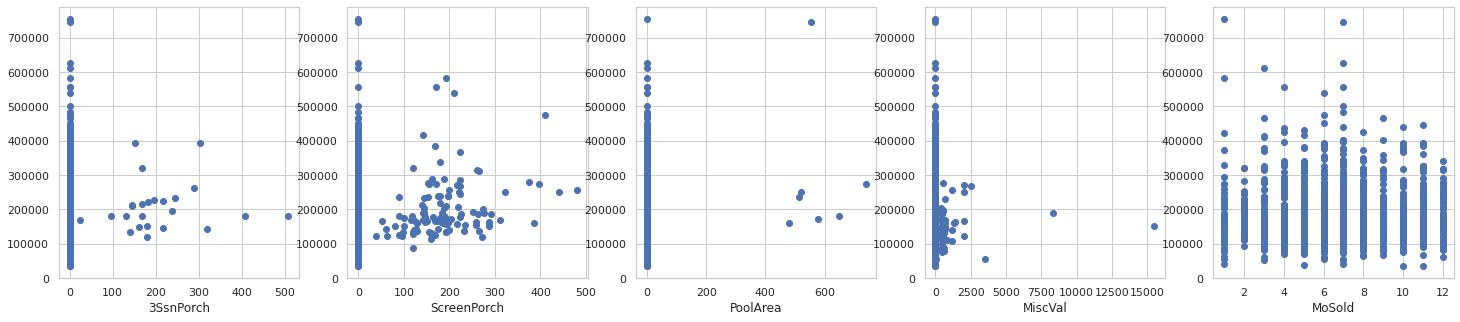

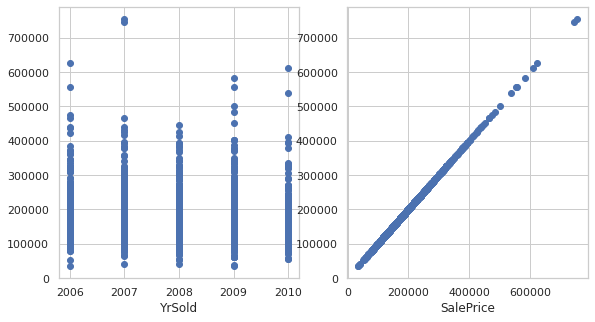

In [165]:
#scatter plot numeric feature/saleprice
# Function show scatter
def scatter_with_feature(df, features, feature_target, figures_per_time = 5):
  count = 0
  for feature in features:
    plt.figure(count//figures_per_time,figsize=(25,5))
    plt.subplot(1,figures_per_time,np.mod(count,figures_per_time)+1)
    plt.scatter(x= feature, y=feature_target, data = df)
    plt.xlabel(feature)
    count += 1

scatter_with_feature(train, numerical_features, 'SalePrice')

- A lot of data points are located on x = 0
- We can clearly identify some relationships. Most of them seems to have a linear relationship with the SalePrice: 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'
       

Correlation matrix (heatmap style)

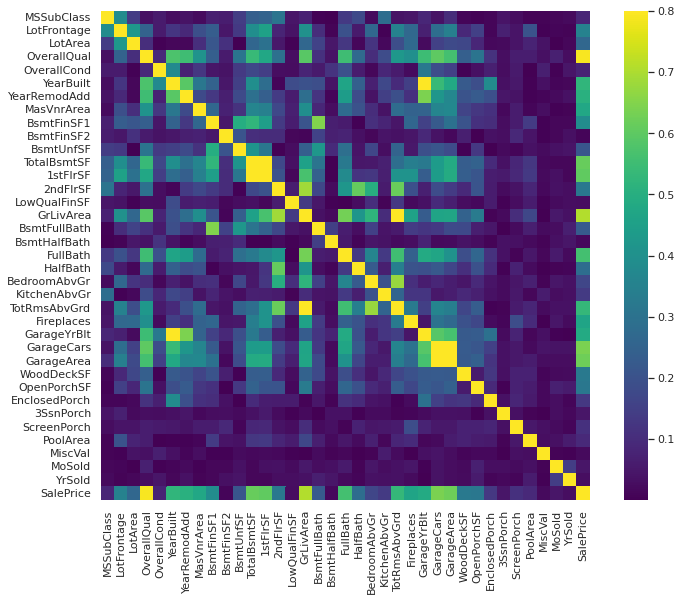

In [166]:
#correlation matrix
corrmat = train.corr().abs()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap='viridis', vmax=.8, square=True);

- The heatmap is the best way to get a quick overview of its relationships
- At first sight, there are two yellow colored squares that get my attention. The first one refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'GarageX' variables. Both cases show how significant the correlation is between these variables.

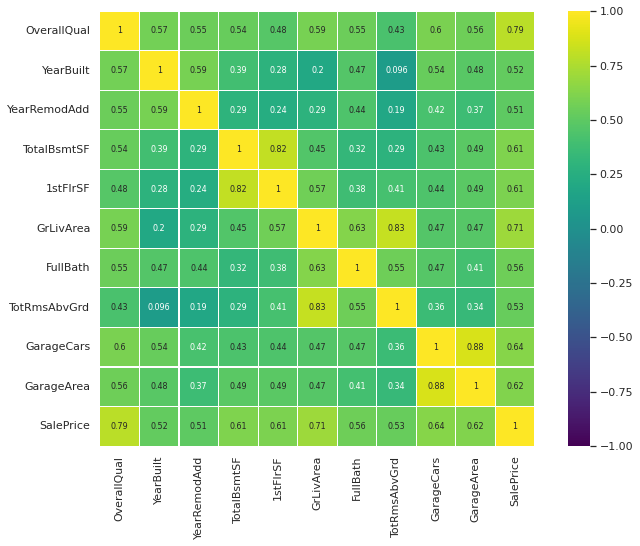

In [167]:
top_feature = corrmat.index[corrmat['SalePrice']>0.5]
plt.subplots(figsize=(12, 8))
top_corr = train[top_feature].corr()
sns.heatmap(top_corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.show()


- According to our heatmap, these are the variables most correlated with 'SalePrice'. My thoughts on this:
'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
- 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, the number of cars that fit into the garage is a consequence of the garage area. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
- 'TotalBsmtSF' and '1stFloor' also seem have most strongly correlated variables. We can keep 'TotalBsmtSF'.
- 'TotRmsAbvGrd' and 'GrLivArea' again.
-  'YearBuilt' is slightly correlated with 'SalePrice'.


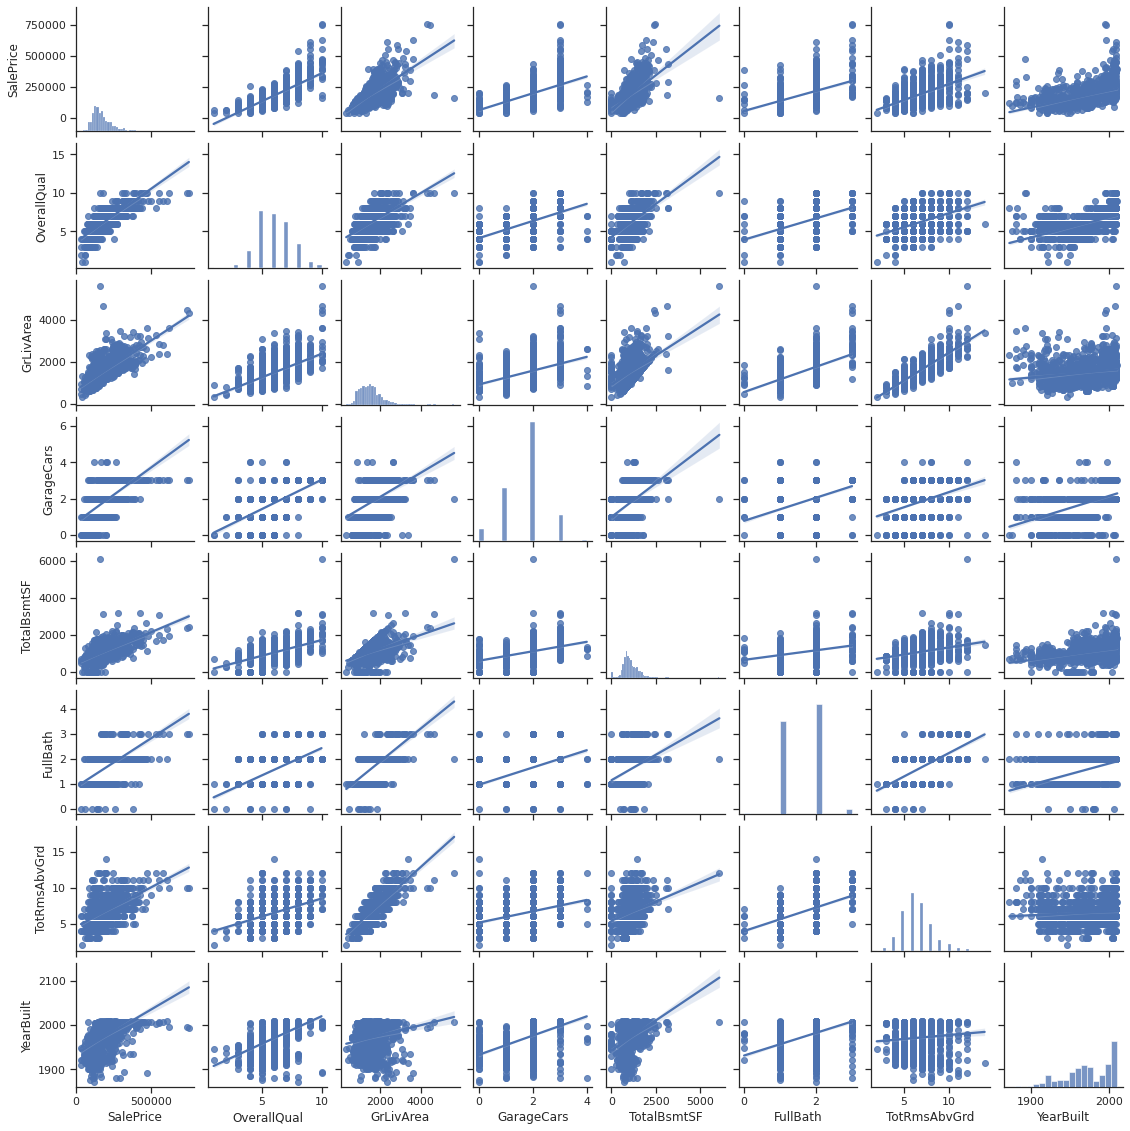

In [168]:
col = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.set(style='ticks')
sns.pairplot(train[col], size=2, kind='reg')

This mega scatter plot gives us a reasonable idea about variables relationships.
- One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line. The majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area

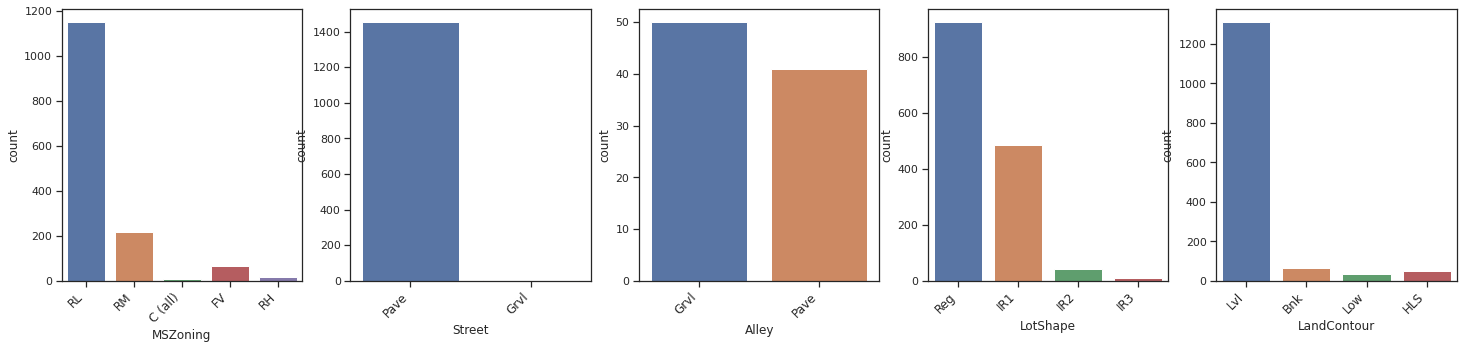

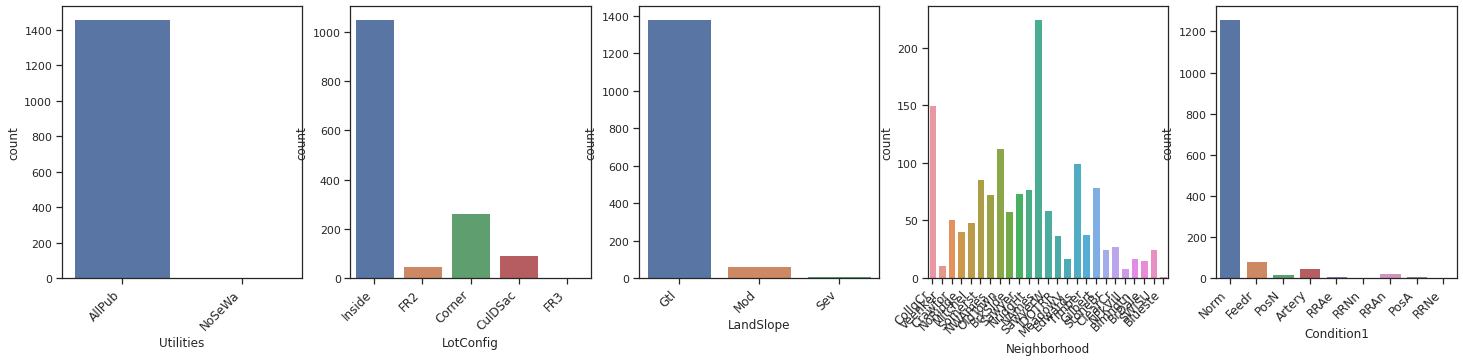

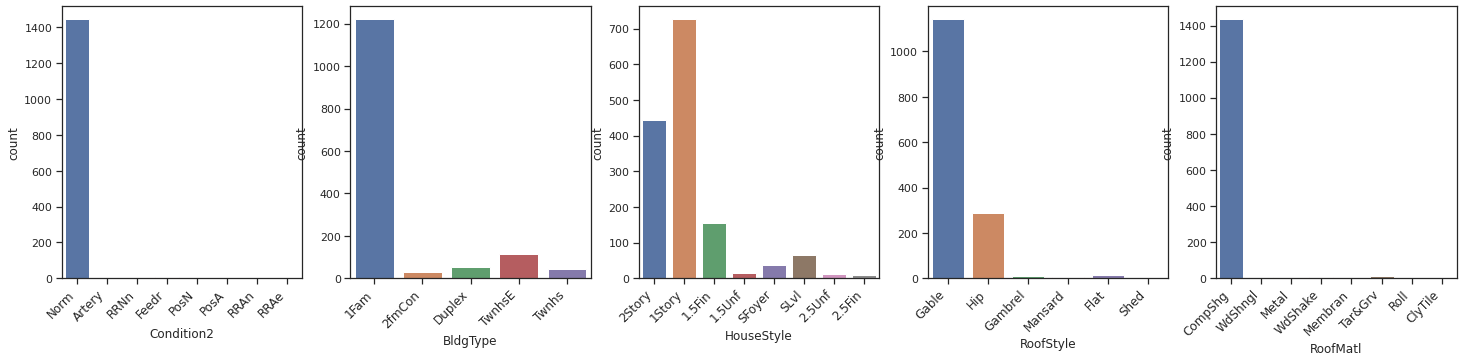

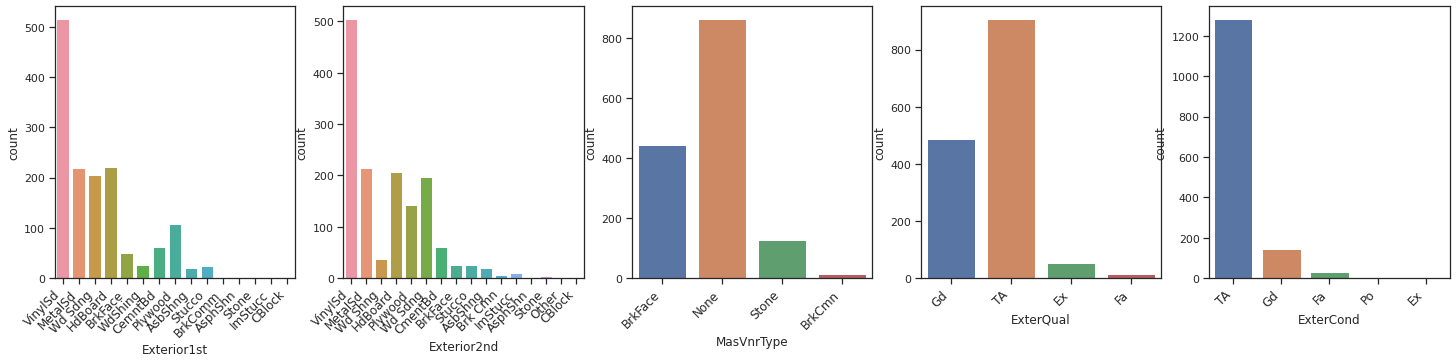

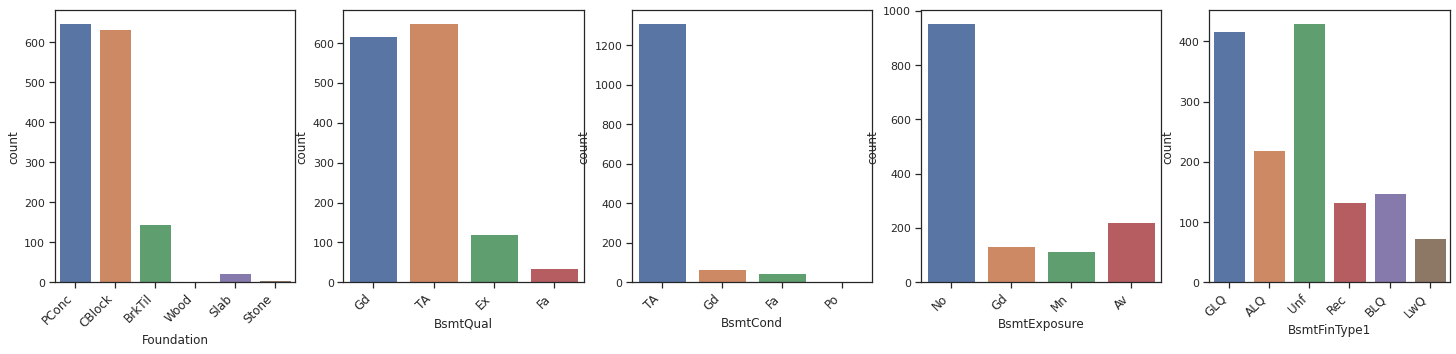

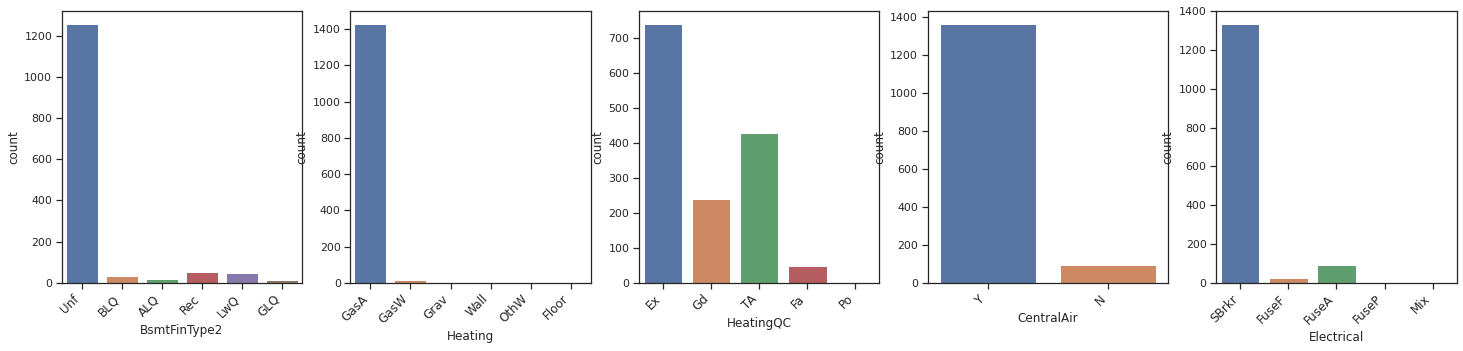

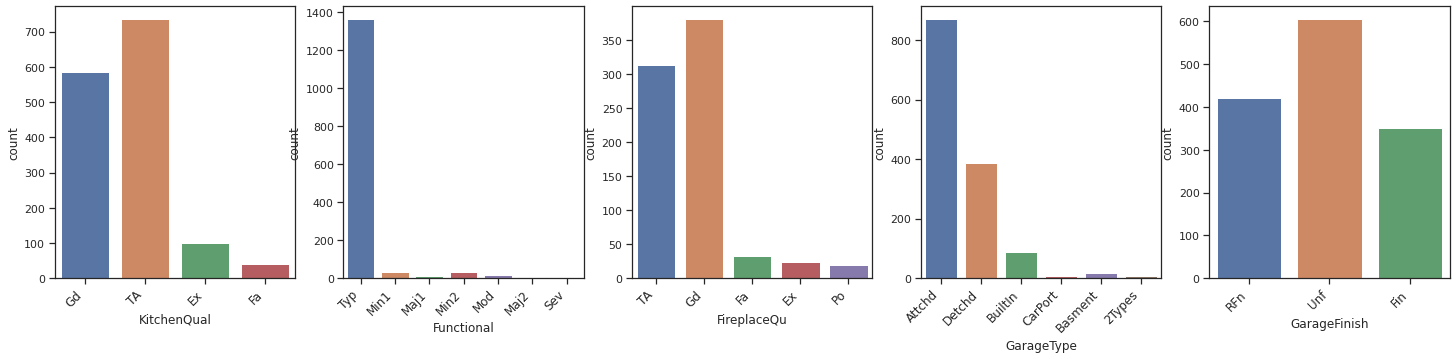

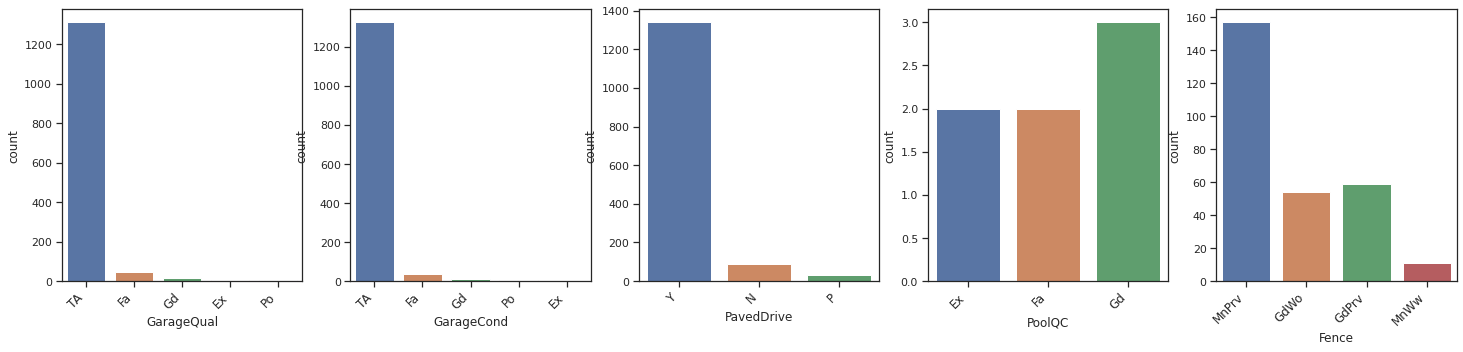

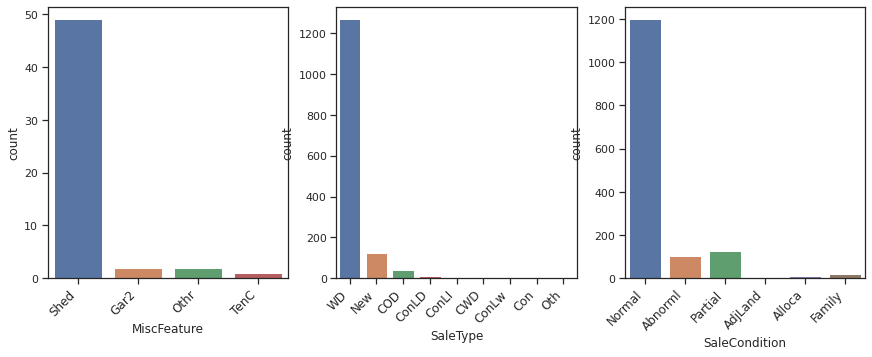

In [169]:
# Distribution non_numerical feature
def countplot_features(df, features, figures_per_time = 5):
  count = 0
  for feature in features:
      plt.figure(count//figures_per_time,figsize=(25,5))
      plt.subplot(1,figures_per_time,np.mod(count,figures_per_time)+1)

      sns.countplot(df[feature])
      plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium'  
        )
      plt.xlabel(feature)
      count += 1

countplot_features(train, non_numerical_features)

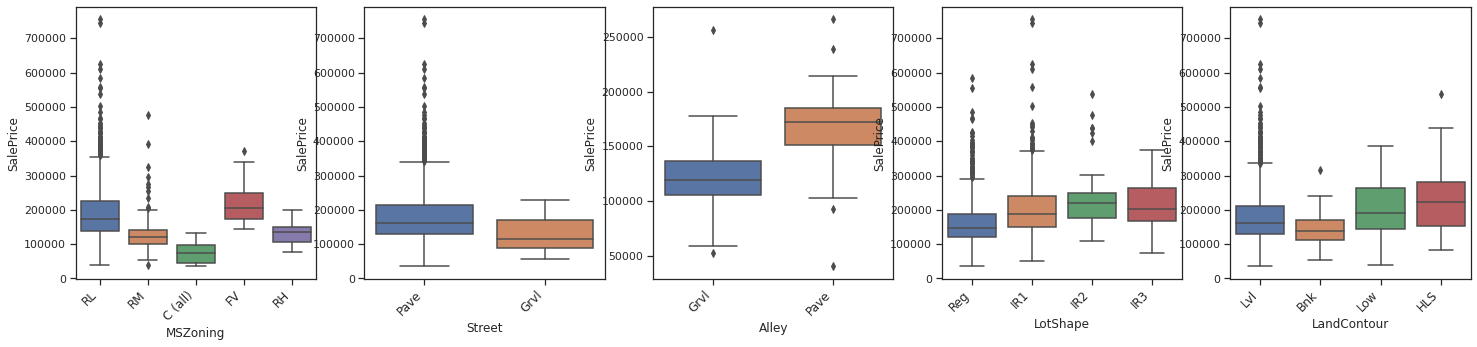

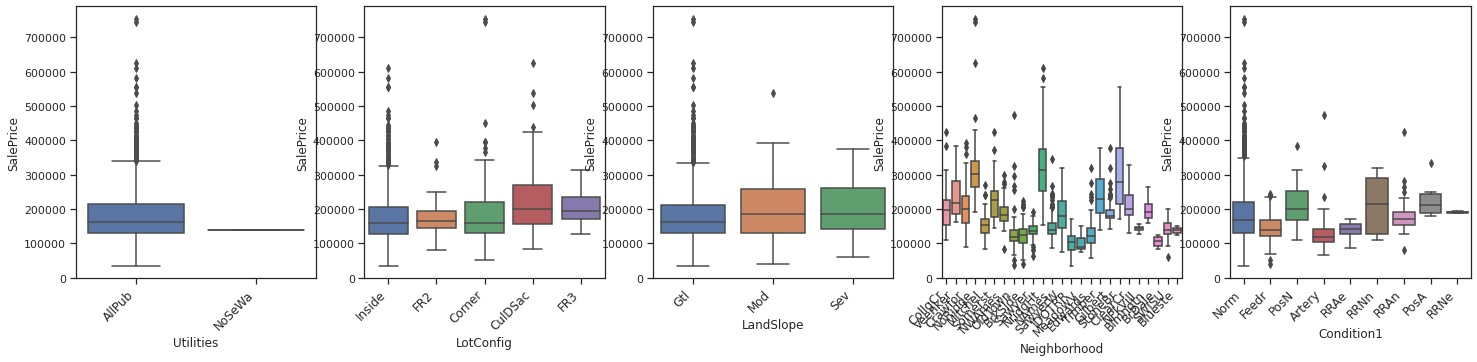

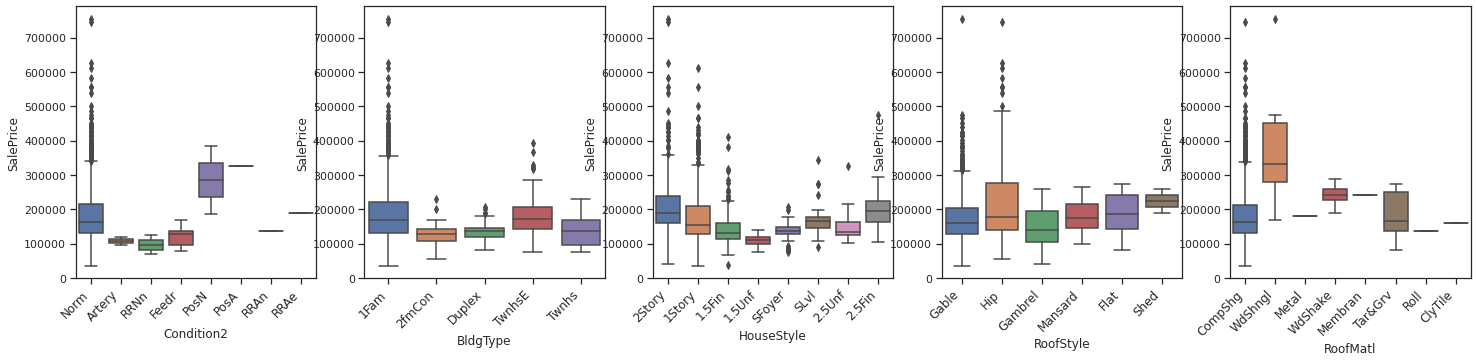

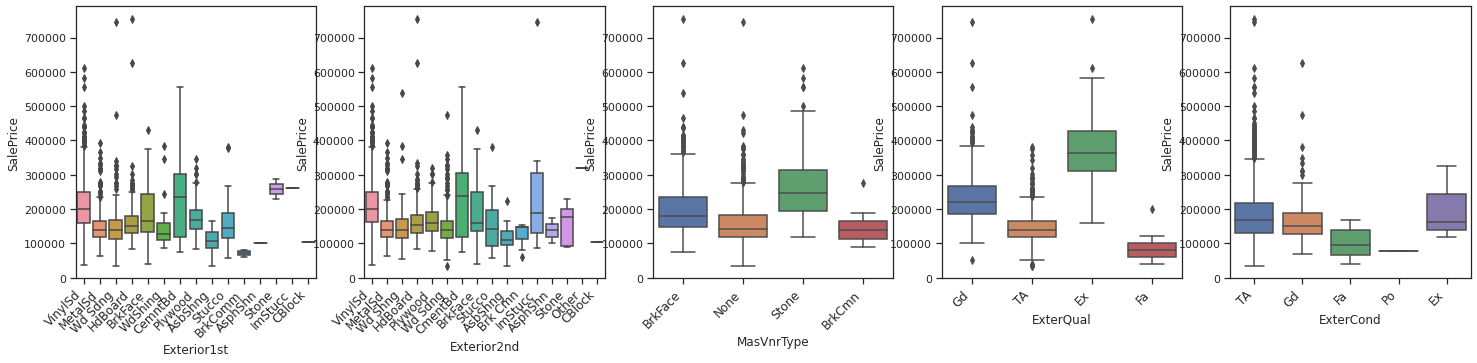

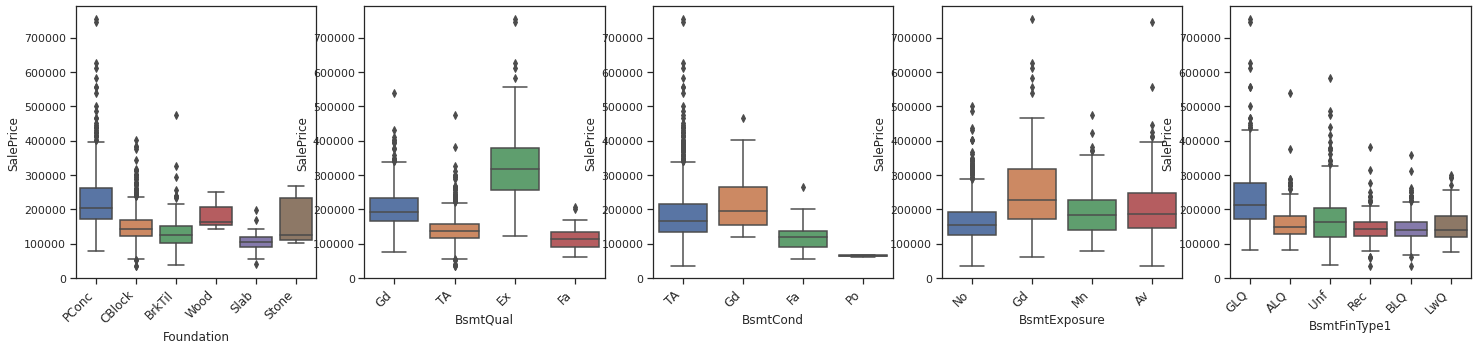

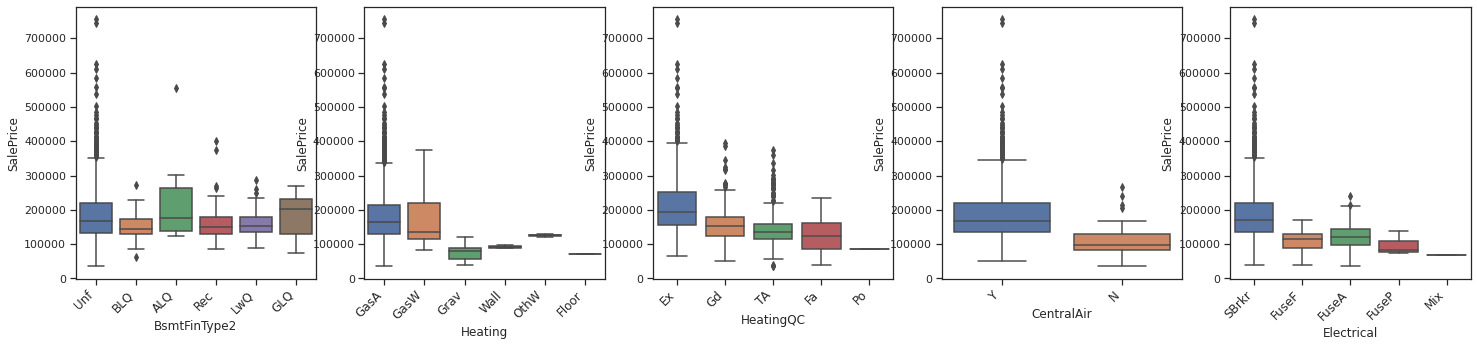

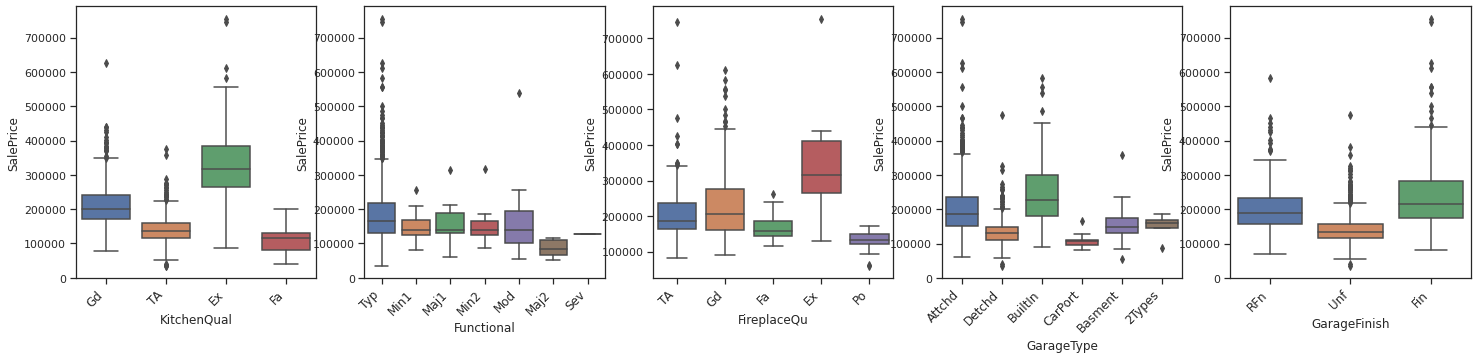

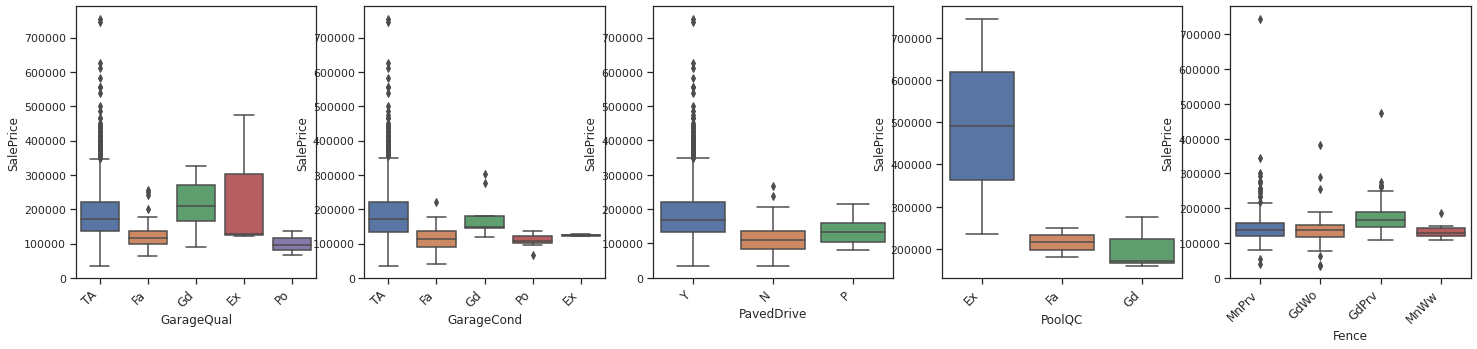

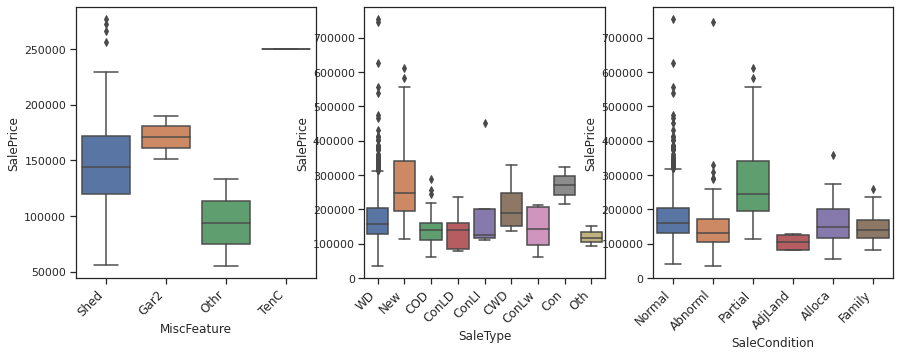

In [170]:
def boxplot_with_features(df, features, target,figures_per_time = 5):
  count = 0
  for feature in features:
    plt.figure(count//figures_per_time,figsize=(25,5))
    plt.subplot(1,figures_per_time,np.mod(count,figures_per_time)+1)

    sns.boxplot(x=feature, y=target, data=df)
    plt.xticks(
      rotation=45, 
      horizontalalignment='right',
      fontweight='light',
      fontsize='medium'  
      )
    count += 1

boxplot_with_features(train, non_numerical_features, 'SalePrice')

# 2. Data cleaning

## Handling Missing value

In [171]:
df_processed = train.copy()

def features_null(df):
  features_with_na = [x for x in df.columns if df[x].isnull().sum()>0]
  print('No. features_with_na = ' + str(len(features_with_na)))
  print('Total NaN = ' + str(df.isnull().values.sum()))
  return features_with_na
features_null(df_processed)

No. features_with_na = 19
Total NaN = 6965


['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [172]:
# We can drop PoolQC, MiscFeature, Alley and Fence features because they have more than 80% of missing values.
df_processed = df_processed.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

We will fill -- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageFinish, GarageQual, FireplaceQu, GarageCond** -- with "None" (Take a look in the data description).
We will fill the rest of features with th most frequent value (using its own most frequent value).

In [173]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
df_processed[columns_None]= df_processed[columns_None].fillna('None')

In [174]:
columns_with_lowNA = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
#fill missing values for each column (using its own most frequent value)
df_processed[columns_with_lowNA] = df_processed[columns_with_lowNA].fillna(df_processed.mode().iloc[0])

In [175]:
# Fill GarageYrBlt base on 'YearBuilt
print((df_processed['YrSold'] - df_processed['YearBuilt']).median())

35.0


In [176]:
# So we will fill the GarageYrBlt = YearBuilt - 35
df_processed['GarageYrBlt'] = df_processed['GarageYrBlt'].fillna(df_processed['YrSold']-35)

In [177]:
# we will fill the Lot frontage with median**
df_processed['LotFrontage'] = df_processed['LotFrontage'].fillna(df_processed["LotFrontage"].median())

In [178]:
# Fill MasVnrArea with 0
df_processed['MasVnrArea'] = df_processed['MasVnrArea'].fillna(0)

In [179]:
features_null(df_processed)

No. features_with_na = 0
Total NaN = 0


[]

**We finally end up with a clean dataset**


In [180]:
# After making some plots we found that we have some colums with low variance so we decide to delete them
df_processed = df_processed.drop(['Heating','RoofMatl','Condition2','Street','Utilities'],axis=1)


Now we will create some new features



In [181]:
# Create age of houses
df_processed['Age_House']= (df_processed['YrSold']-df_processed['YearBuilt'])
df_processed['Age_House'].describe()

count    1460.000000
mean       36.547945
std        30.250152
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: Age_House, dtype: float64

- TotalBsmtBath : Sum of : BsmtFullBath and 1/2 BsmtHalfBath
- TotalBath : Sum of : FullBath and 1/2 HalfBath
- TotalSA : Sum of : 1stFlrSF and 2ndFlrSF and basement area

In [182]:
df_processed['TotalBsmtBath'] = df_processed['BsmtFullBath'] + df_processed['BsmtFullBath']*0.5
df_processed['TotalBath'] = df_processed['FullBath'] + df_processed['HalfBath']*0.5 
df_processed['TotalSA']=df_processed['TotalBsmtSF'] + df_processed['1stFlrSF'] + df_processed['2ndFlrSF']
df_processed.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,0,2,2008,WD,Normal,208500,5,1.5,2.5,2566
1,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0,5,2007,WD,Normal,181500,31,0.0,2.0,2524
2,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,0,9,2008,WD,Normal,223500,7,1.5,2.5,2706
3,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,0,2,2006,WD,Abnorml,140000,91,1.5,1.0,2473
4,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,0,12,2008,WD,Normal,250000,8,1.5,2.5,3343


**Now the next step is to encode categorical features**

In [183]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6}

df_processed['ExterQual'] = df_processed['ExterQual'].map(bin_map)
df_processed['ExterCond'] = df_processed['ExterCond'].map(bin_map)
df_processed['BsmtCond'] = df_processed['BsmtCond'].map(bin_map)
df_processed['BsmtQual'] = df_processed['BsmtQual'].map(bin_map)
df_processed['HeatingQC'] = df_processed['HeatingQC'].map(bin_map)
df_processed['KitchenQual'] = df_processed['KitchenQual'].map(bin_map)
df_processed['FireplaceQu'] = df_processed['FireplaceQu'].map(bin_map)
df_processed['GarageQual'] = df_processed['GarageQual'].map(bin_map)
df_processed['GarageCond'] = df_processed['GarageCond'].map(bin_map)
df_processed['CentralAir'] = df_processed['CentralAir'].map(bin_map)
df_processed['LotShape'] = df_processed['LotShape'].map(bin_map)
df_processed['BsmtExposure'] = df_processed['BsmtExposure'].map(bin_map)
df_processed['BsmtFinType1'] = df_processed['BsmtFinType1'].map(bin_map)
df_processed['BsmtFinType2'] = df_processed['BsmtFinType2'].map(bin_map)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
df_processed['PavedDrive'] = df_processed['PavedDrive'].map(PavedDrive)

Will we use One hot encoder to encode the rest of categorical features

In [184]:
#Select categorical features
rest_object_columns = df_processed.select_dtypes(include=['object'])
#Using One hot encoder
df_processed = pd.get_dummies(df_processed, columns=rest_object_columns.columns) 

In [185]:
df_processed.head()

,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,3,7,5,2003,2003,196.0,4,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,3,6,8,1976,1976,0.0,2,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,2,7,5,2001,2002,162.0,4,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,2,7,5,1915,1970,0.0,2,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,2,8,5,2000,2000,350.0,4,...,0,0,0,1,0,0,0,0,1,0


The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.


 mu = 12.02 and sigma = 0.40



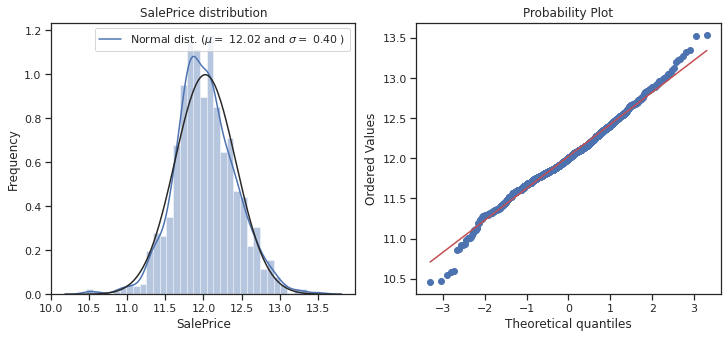

In [186]:
#we use log function which is in numpy
df_processed['SalePrice'] = np.log1p(df_processed['SalePrice'])

#Check again for more normal distribution

feature_distribution(df_processed['SalePrice'])

## 3. Model building

In [187]:
from sklearn.model_selection import train_test_split
X = df_processed.drop('SalePrice', axis=1)
y = df_processed['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print('Shape')
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))
print('y_train: ' + str(y_train.shape))
print('y_test: ' + str(y_test.shape))

Shape
X_train: (1022, 204)
X_test: (438, 204)
y_train: (1022,)
y_test: (438,)


In [188]:
def plot_test_predict(test, predict):
  plt.figure(figsize=(10,10))
  plt.scatter(test, predict, c='crimson')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(predict), max(test))
  p2 = min(min(predict), min(test))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')

**Random Forest Regression**: A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [189]:
#Train the model
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=200) #n_estimators: The number of trees in the forest.

#Fit
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)
#Score/Accuracy
print("Accuracy --> ", rfr.score(X_test, y_test)*100)

Accuracy -->  85.53703844507965


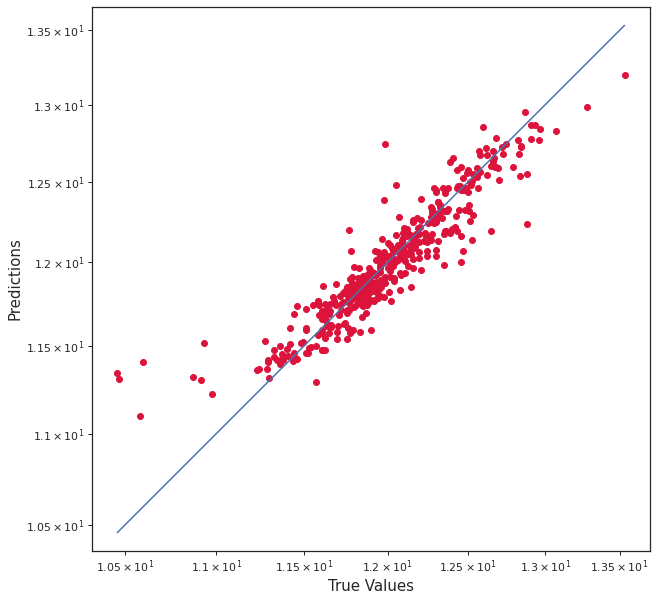

In [190]:
plot_test_predict(y_test, y_pred_rfr)

**Gradient Boosting Regressor**: GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

In [191]:
#Train the model
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=200, max_depth=4)
#Fit
GBR.fit(X_train, y_train)
y_pred_GBR = GBR.predict(X_test)
print("Accuracy --> ", GBR.score(X_test, y_test)*100)

Accuracy -->  88.85545932382513


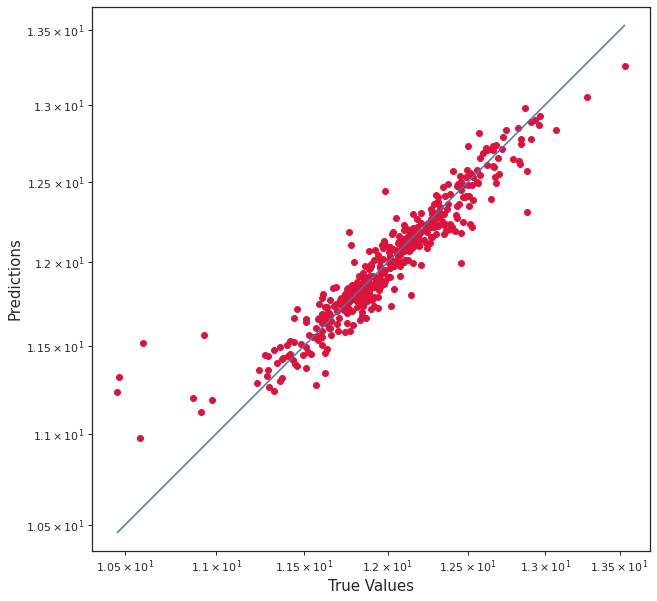

In [192]:
plot_test_predict(y_test, y_pred_GBR)

In [193]:
from xgboost import XGBRegressor
xgb =XGBRegressor( booster='gbtree', learning_rate=0.01,
             max_depth=4, min_child_weight=1.5, n_estimators=2400
             )
#Fit
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("Accuracy --> ", xgb.score(X_test, y_test)*100)

[03:51:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy -->  89.50879642106753


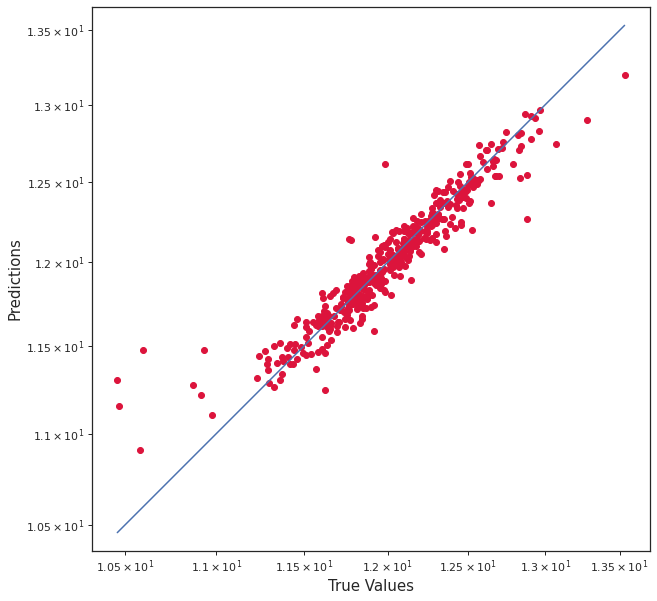

In [194]:
plot_test_predict(y_test, y_pred_xgb)